## Process the Label Array with WhisperSeg Vocalization Areas

In [1]:
import numpy as np

f = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/labels_for_training_classifier.npz"

# load the npz file
data = np.load(f)
# -1 will denote noise as well as silences and non-vocalizations etc
vocalization = data['vocalization']
labels = data['hdbscan_labels']
specs = data['original_spectogram']

# pad the first 20 spec dimensions with zeros, so that the dataclass doesnt need to be changed
specs = np.pad(specs, ((0, 0), (20, 0)), 'constant', constant_values=0)


# Goal is to create an array of labels, where the vocalized portions get the HDBSCAN labels, and non vocalized portions get a -1 label

# Create a copy of the vocalization array
temp = np.copy(vocalization)

# set all values to -1 
temp[:] = -1

indexes = np.where(vocalization == 1.0)[0]

for i, index in enumerate(indexes):
    temp[index] = labels[i]
labels = temp

# increase all labels by 1
labels += 1

num_classes = len(np.unique(labels))

# # Save labels, specs, and vocalization in an NPZ file for Tim
# output_file = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/labels_specs_vocalization.npz"
# np.savez(output_file, labels=labels, specs=specs, vocalization=vocalization)

## Train Test Split

In [2]:
import os
import shutil

linear_decoder_test_dir = "/media/george-vengrovski/disk1/linear_decoder_test"
linear_decoder_train_dir = "/media/george-vengrovski/disk1/linear_decoder_train"

# if dir exists, delete all the data inside
if os.path.exists(linear_decoder_test_dir):
    shutil.rmtree(linear_decoder_test_dir)
os.makedirs(linear_decoder_test_dir)

if os.path.exists(linear_decoder_train_dir):
    shutil.rmtree(linear_decoder_train_dir)
os.makedirs(linear_decoder_train_dir)

length = 1000
test_train_split = 0.8

# temp storage before train test split 
list_of_data = []

# we need labels and specs saved to npz 
for i in range(0, len(labels), length):
    list_of_data.append((labels[i:i+length], specs[i:i+length], vocalization[i:i+length]))

# shuffle the list of data
np.random.shuffle(list_of_data)

# split the list of data into train and test
train_data = list_of_data[:int(len(list_of_data)*test_train_split)]
test_data = list_of_data[int(len(list_of_data)*test_train_split):]

# Print the shape of all data points in train and test data
print("Train Data Shapes:")
for i, data in enumerate(train_data):
    print(f"Data point {i}: labels shape {data[0].shape}, specs shape {data[1].T.shape}, vocalization shape {data[2].shape}")
    np.savez(linear_decoder_train_dir + "/" + str(i) + ".npz", labels=data[0], s=data[1].T, vocalization=data[2])

print("Test Data Shapes:")
for i, data in enumerate(test_data):
    print(f"Data point {i}: labels shape {data[0].shape}, specs shape {data[1].T.shape}, vocalization shape {data[2].shape}")
    np.savez(linear_decoder_test_dir + "/" + str(i) + ".npz", labels=data[0], s=data[1].T, vocalization=data[2])

Train Data Shapes:
Data point 0: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 1: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 2: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 3: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 4: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 5: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 6: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 7: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 8: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 9: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 10: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 1

## Train Linear Classifier

In [3]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import CollateFunction
from utils import load_model

weights_path = "experiments/PitchShiftTest/saved_weights/model_step_12500.pth"
config_path = "experiments/PitchShiftTest/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

linear_decoder_test_dir = "/media/george-vengrovski/disk1/linear_decoder_test"
linear_decoder_train_dir = "/media/george-vengrovski/disk1/linear_decoder_train"

train_dataset = SongDataSet_Image(linear_decoder_train_dir, num_classes=num_classes, infinite_loader=False)
test_dataset = SongDataSet_Image(linear_decoder_test_dir, num_classes=num_classes, infinite_loader=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)

In [8]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=num_classes, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=-2, layer_id="attention_output", classifier_dims=196)
classifier_model = classifier_model.to(device)

Step 100: Train Loss 0.1611 FER = 7.66%, Val Loss = 0.2316
Step 200: Train Loss 0.1003 FER = 3.27%, Val Loss = 0.0962
Step 300: Train Loss 0.0783 FER = 3.39%, Val Loss = 0.0986
Step 400: Train Loss 0.0880 FER = 3.91%, Val Loss = 0.1017
Step 500: Train Loss 0.0626 FER = 4.10%, Val Loss = 0.1118


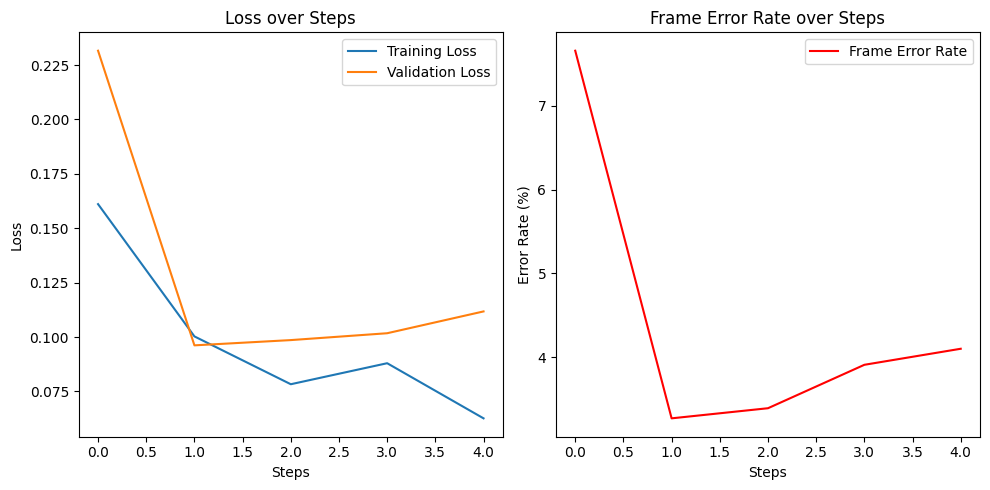

In [9]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-5, plotting=True, batches_per_eval=100, desired_total_batches=500, patience=4)
trainer.train()

## Generate Some Specs For Evalulation Purposes

In [10]:
import matplotlib.pyplot as plt
import shutil
import os
import numpy as np
import torch

class SpecGenerator:
    def __init__(self, model, song_dir, context_length=1000):
        self.num_classes = num_classes
        self.model = model
        self.song_dir = song_dir
        self.context_length = context_length
        self.spec_height = 196

    def z_score_spectrogram(self, spec):
        spec_mean = np.mean(spec)
        spec_std = np.std(spec)
        return (spec - spec_mean) / spec_std

    def process_spec_chunk(self, spec_chunk, label_chunk, output_dir, file, i):
        spec_tensor = torch.Tensor(spec_chunk).to(device).unsqueeze(0).unsqueeze(0)
        logits = self.model.forward(spec_tensor)
        predicted_classes = torch.argmax(logits, dim=2).cpu().detach().numpy().flatten()
        self.plot_and_save(spec_chunk, predicted_classes, label_chunk, logits, output_dir, file, i)

    def plot_and_save(self, spec_chunk, predicted_classes, label_chunk, logits, output_dir, file, i):
        color_map = plt.get_cmap('viridis')
        class_colors = color_map(predicted_classes / self.num_classes)

        plt.figure(figsize=(15, 15))
        plt.subplots_adjust(hspace=1.5, left=0, right=1, top=1, bottom=0)
        plt.subplot2grid((15, 1), (0, 0), rowspan=8)
        plt.imshow(spec_chunk, aspect='auto', origin='lower')
        plt.title('Spectrogram', fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.subplot2grid((15, 1), (8, 0), rowspan=1)
        plt.imshow([predicted_classes], aspect='auto', origin='lower', cmap='viridis')
        plt.title('Predicted Classes', fontsize=24)
        plt.yticks([])
        plt.xticks([])
        plt.subplot2grid((15, 1), (9, 0), rowspan=1)
        plt.imshow([label_chunk], aspect='auto', origin='lower', cmap='viridis')
        plt.title('True Labels', fontsize=24)
        plt.yticks([])
        plt.xticks([])
        plt.subplot2grid((15, 1), (10, 0), rowspan=4)
        plt.imshow(logits[0].T.cpu().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
        plt.title('Logits Heatmap', fontsize=24)
        plt.xlabel('Timebins', fontsize=24)
        plt.ylabel('Logits', fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.savefig(f"{output_dir}/{file}_chunk_{i}.png", bbox_inches='tight')
        plt.close()

    def generate_specs(self, num_specs):
        output_dir = "imgs/decoder_specs"
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        os.makedirs(output_dir)
        
        processed_specs = 0
        for file in os.listdir(self.song_dir):
            if processed_specs >= num_specs:
                break

            data = np.load(os.path.join(self.song_dir, file))
            spec = data['s']
            labels = data['labels']

            spec_length = spec.shape[1]
            spec_height = spec.shape[0]

            if spec_height > self.spec_height:
                spec = spec[20:216, :]
            
            spec = self.z_score_spectrogram(spec)

            if spec_length > self.context_length:
                num_splits = (spec_length // self.context_length) + 1
                for i in range(num_splits):
                    if processed_specs >= num_specs:
                        break

                    if i == num_splits - 1:
                        spec_chunk = spec[:, i*self.context_length:]
                        label_chunk = labels[i*self.context_length:]
                    else:
                        spec_chunk = spec[:, i*self.context_length:(i+1)*self.context_length]
                        label_chunk = labels[i*self.context_length:(i+1)*self.context_length]

                    self.process_spec_chunk(spec_chunk, label_chunk, output_dir, file, i)
                    processed_specs += 1
            else:
                self.process_spec_chunk(spec, labels, output_dir, file, "")
                processed_specs += 1

SpecGenerator = SpecGenerator(classifier_model, song_dir="/media/george-vengrovski/disk1/linear_decoder_test")
SpecGenerator.generate_specs(100)